In [117]:
# !pip install pymorphy2 cleantext -U nlp_profiler textblob pymystem3
import os
import sys
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.insert(1, '/kaggle/input/ods-huawei/nlp_huawei_new2_task-master/nlp_huawei_new2_task-master/baseline_transformers')
# from dataset import *
# from model import *
# from trainer import Trainer

import torch
from torch.utils.data import Dataset
from typing import Dict
import json
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW, SGD, Rprop, Adadelta, Adamax, SparseAdam, NAdam, RAdam
from tqdm.notebook import tqdm
from textblob import TextBlob

torch.manual_seed(42)

In [141]:
from sklearn.model_selection import StratifiedKFold

class FiveDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        if 'summary' in dataframe:
            self.text = dataframe['summary'].tolist()
#         else:
#             self.text = dataframe['text'].tolist()
        self.targets = None
        if 'rate' in dataframe:
            self.targets = dataframe['rate'].tolist()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
            }

    def __len__(self) -> int:
        return len(self.text)
    

class ModelForClassification(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict):
        super(ModelForClassification, self).__init__()
        self.model_name = model_path
        self.config = config
        self.n_classes = config['num_classes']
        self.dropout_rate = config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name)
        self.pre_classifier = torch.nn.Linear(312, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(768, self.n_classes)
        self.softmax = torch.nn.LogSoftmax(dim = 1)

    def forward(self, input_ids, attention_mask,):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = output[0]
        hidden_state = hidden_state[:, 0]
        hidden_state = self.pre_classifier(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        hidden_state = self.dropout(hidden_state)
        output = self.classifier(hidden_state)
        output = self.softmax(output)
        return output


class Trainer:
    def __init__(self, config: Dict, class_weights=None):
        self.config = config
        self.device = config['device']
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: Adamax(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            self.loss_fn = CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)
        
    def save_history(self, path: str):
        history = {
            'train_loss': self.history['train_loss'],
            'val_loss': self.history['val_loss'],
            'val_acc': self.history['val_acc']
        }
        val_acc = sum(self.history['val_acc']) / len(self.history['val_acc'])
        print("All ACCURACY = ", val_acc)
        with open(path, 'w') as file:
            json.dump(history, file)
        
    def load_history(self, path: str):
        with open(path, 'r') as file:
            history = json.load(file)
        self.history = {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc']
        }

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
        best_val_loss = float('inf')

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])

            if val_info['loss'] < best_val_loss:
                best_val_loss = val_info['loss']
                self.save_model_weights('best_model_weights.ckpt')

            self.save_history('history.json')

        return self.model.eval()

    def save_model_weights(self, path: str):
        torch.save(self.model.state_dict(), path)



    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        total_loss = 0
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)
            total_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        avg_loss = total_loss / len(train_dataloader)
        print("AVG LOSS = ", avg_loss)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print("ACCURACY for EPOCH = ", acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                preds = torch.exp(outputs)
                predictions.extend(preds.tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    def plot_history(self):
        import matplotlib.pyplot as plt
        
        if self.history is None:
            raise RuntimeError("History is not available. Train the model first.")

        train_loss = self.history['train_loss']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_acc']

        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

# Data load

In [142]:
train = pd.read_csv('/kaggle/input/ods-huawei/new_train.csv')
f_train = pd.read_csv('/kaggle/input/ods-huawei/feature_train.csv')
train_data = pd.concat([f_train['rate'], train], axis=1)

# Train Test split

In [157]:
# train_split, val_split = train_test_split(train_data[train_data['rate'] != 4], test_size=0.15, random_state=42, 
#                                           shuffle = True, stratify=train_data[train_data['rate'] != 4]['rate'])

train_split, val_split = train_test_split(train_data, test_size=0.25, random_state=42, 
                                          shuffle = True, stratify=train_data['rate'])

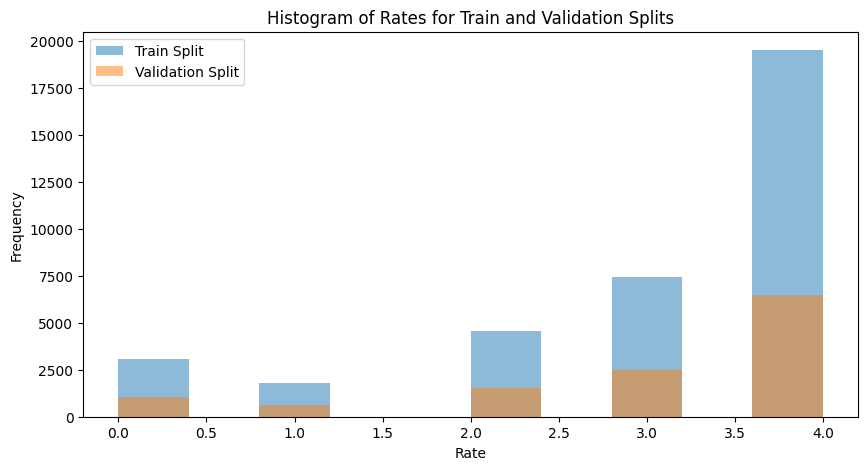

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(train_split['rate'], bins=10, alpha=0.5, label='Train Split')
plt.hist(val_split['rate'], bins=10, alpha=0.5, label='Validation Split')

plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Rates for Train and Validation Splits')

plt.show()

# Loading tokenizer from pretrained

In [159]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

# Creating train dataset

In [160]:
MAX_LEN = 128
BATCH_SIZE = 64
train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN)
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN)
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)

# Loading pretrained model from Huggingface

In [161]:
config = {
    "num_classes": len(np.unique(train_split['rate'])),
    "dropout_rate": 0.1
}
model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config
)

# Fitting the model

In [162]:
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 2,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = Trainer(trainer_config)

t.fit(
    model,
    train_dataloader,
    val_dataloader
)

Epoch 1/2


  0%|          | 0/570 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.9232774400920198


  0%|          | 0/190 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.6498355269432068
All ACCURACY =  0.6498355269432068
Epoch 2/2


  0%|          | 0/570 [00:00<?, ?it/s]

AVG LOSS =  0.8394428447673196


  0%|          | 0/190 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.6528783440589905
All ACCURACY =  0.6513569355010986


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

# Save model

In [ ]:
t.save("best_baseline_model.ckpt")

# Load pretrained Model

In [ ]:
t = Trainer.load("best_baseline_model.ckpt")

# Get testset predictions


In [166]:
test_data = pd.read_csv('/kaggle/input/ods-huawei/test_cleaned.csv')
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, **test_params)

In [167]:
predictions = t.predict(test_dataloader)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [168]:
predicted_classes = [np.argmax(probabilities) + 1 for probabilities in predictions]

# Create submission


In [170]:
sample_submission = pd.read_csv('/kaggle/input/ods-huawei/sample_submission.csv')
sample_submission["rate"] = predicted_classes
# sample_submission.rate = le.inverse_transform(sample_submission.rate)
sample_submission.head()

,index,rate
0,0,5
1,1,5
2,2,5
3,3,4
4,4,4


In [171]:
sample_submission.to_csv("submission.csv", index=False)

# Val conf matrix

In [183]:
predictions_val = t.predict(val_dataloader)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [184]:
predicted_classes_val = [np.argmax(probabilities) + 1 for probabilities in predictions_val]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for val dataset:
               precision    recall  f1-score   support

           1       0.58      0.59      0.58      1032
           2       0.00      0.00      0.00         0
           3       0.39      0.40      0.39      1479
           4       0.43      0.43      0.43      2490
           5       0.87      0.79      0.83      7159

    accuracy                           0.65     12160
   macro avg       0.45      0.44      0.45     12160
weighted avg       0.70      0.65      0.67     12160



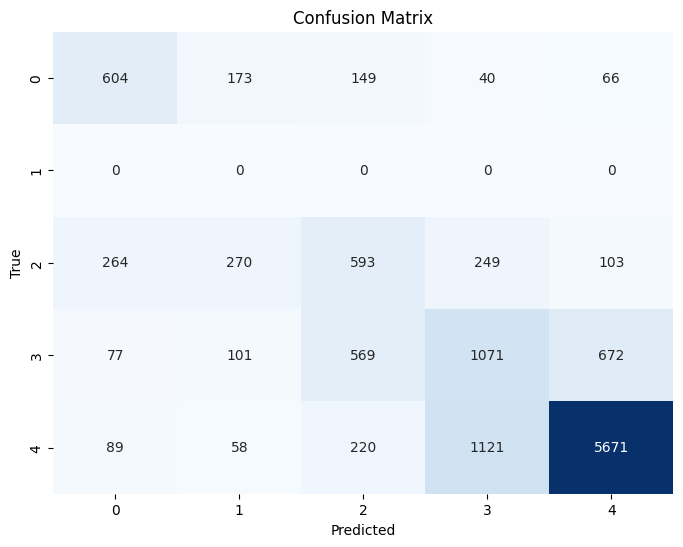

In [179]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "/kaggle/input/ods-huawei/"
temp_data = pd.read_csv(os.path.join(PATH, "train.csv"))
le = LabelEncoder()
temp_data.rate = le.fit_transform(temp_data.rate)

def evaluate_classification_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_classification_metrics(predicted_classes_val, le.inverse_transform(val_split['rate']), "val dataset")

# Proba as features

In [186]:
train = pd.read_csv('/kaggle/input/ods-huawei/new_train.csv')
f_train = pd.read_csv('/kaggle/input/ods-huawei/feature_train.csv')
train_data = pd.concat([f_train['rate'], train], axis=1)
test_dataset = FiveDataset(train_data, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset, **test_params)
predictions = t.predict(train_dataloader)
train_proba = pd.DataFrame(predictions, columns=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
train_proba.to_csv("train_proba_tf.csv", index=False)
print(train_proba)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


         1 star   2 stars   3 stars   4 stars   5 stars
0      0.003772  0.001977  0.008098  0.066973  0.919179
1      0.003167  0.004542  0.061430  0.509345  0.421516
2      0.001740  0.001966  0.024004  0.373921  0.598369
3      0.064749  0.116822  0.473843  0.289876  0.054710
4      0.002417  0.003208  0.039758  0.402271  0.552346
...         ...       ...       ...       ...       ...
36475  0.020511  0.033678  0.215393  0.566609  0.163809
36476  0.003004  0.005957  0.055455  0.461514  0.474070
36477  0.011913  0.029396  0.140713  0.548773  0.269205
36478  0.000683  0.000707  0.007736  0.204599  0.786274
36479  0.168008  0.060835  0.130304  0.114720  0.526133

[36480 rows x 5 columns]
